In [39]:
# Author: Brandon Botzer
# Date: 3/30/2024
# Class: Penn State - AI 879

Tasks:

Problem:

Take at least three pictures of your own in a panorama style and stitch them together in one panoramic image. Use the algorithm in 12.2 (use either SIFT or SURF feature) and then add RANSAC to trim the matching features. Compare the result with/without RANSAC triming. Python user could check this link as reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html



In [40]:
# Imports for functions

from PIL import Image

import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2 as cv


# Showing the results of scipy computations
import pandas as pd

cv.__version__, ski.__version__

('4.8.1', '0.22.0')

# Read in the three images

In [41]:
# Read in the images
im1 = ski.io.imread('Library1.jpg')
im2 = ski.io.imread('Library2.jpg')
im3 = ski.io.imread('Library3.jpg')

# Convert these to grayscale knowing the SIFT needs grayscale
im1 = ski.color.rgb2gray(im1)
im2 = ski.color.rgb2gray(im2)
im3 = ski.color.rgb2gray(im3)

# For some reason these get rotated from my phone
im1 = ski.transform.rotate(im1, -90)
im2 = ski.transform.rotate(im2, -90)
im3 = ski.transform.rotate(im3, -90)

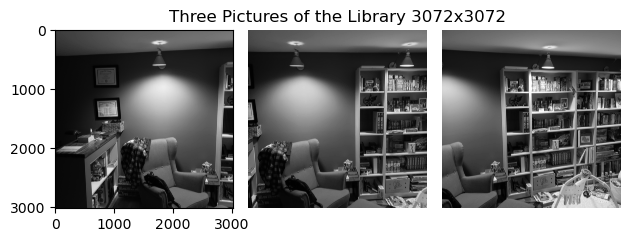

In [42]:
# Showing the pictures to be stitched
fig, axs = plt.subplots(1,3)

axs[0].imshow(im1, cmap='gray')
# axs[0].axis('off')
axs[1].imshow(im2, cmap='gray')
axs[1].axis('off')
axs[2].imshow(im3, cmap='gray')
axs[2].axis('off')

axs[1].set_title('Three Pictures of the Library 3072x3072')

plt.tight_layout()

There is a good chance that the images I take with my phone camera are going to be a very high resolution.  This will cause issues for my machine when running the SIFT algorithm.  To address this, I'll resize the images using skimage and use a Gaussian filter to smooth the images and reduce aliasing.

In [43]:
# Declare an image size
resize_shape = (400, 400)

# The order=3 corresponds to a bi-cubic interpolation
# The anti_aliasing=True applies the Gaussian Filter
im1 = ski.transform.resize(im1, resize_shape, order=3, anti_aliasing=True)
im2 = ski.transform.resize(im2, resize_shape, order=3, anti_aliasing=True)
im3 = ski.transform.resize(im3, resize_shape, order=3, anti_aliasing=True)

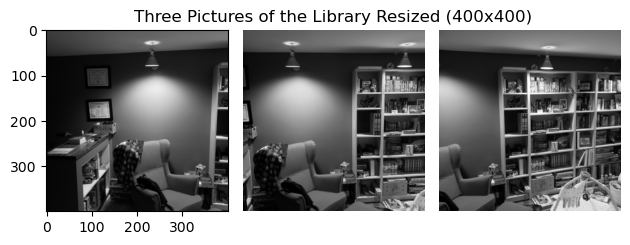

In [44]:
# Showing the resized pictures to be stitched
fig, axs = plt.subplots(1,3)

axs[0].imshow(im1, cmap='gray')
# axs[0].axis('off')
axs[1].imshow(im2, cmap='gray')
axs[1].axis('off')
axs[2].imshow(im3, cmap='gray')
axs[2].axis('off')

axs[1].set_title('Three Pictures of the Library Resized (400x400)')

plt.tight_layout()

# The SIFT Function

In [45]:
# Bring in a modified applySIFT() function from what I built from Lesson 7 Homework

# Using skimage functions
def applySIFT(im1, im2, every_n_element=30, plot=False, title=''):

    '''
    Apply the SIFT Feature Extractor to an image and the same image that has been transformed.
    These found points are then matched between the two images and the matches are plotted.

    WARNING: This is crashing my machine for high-resolution images... Make sure you rescale!

    Args:
        im1: The first image

        im2: The second image which will be compared to the first.

        every_n_element: Given the many SIFT features that are found, this shows every n'th element

        title: plot title

    Returns:
        matches: the matching points between the two images as determined by SIFT
    '''

    # Change a color image to grayscale
    if len(im1.shape) > 2:
        im1 = ski.color.rgb2gray(im1)
    if len(im2.shape) > 2:
        im2 = ski.color.rgb2gray(im2)

    # Built the descriptor object.
        # This object will do the detecting and extracting of the features
        # The default SIFT parameters need 51GB of RAM to operate on the images.
        # I am decreasing the number of octaves to run.
    descriptor_extractor_SFIT = ski.feature.SIFT(n_octaves=3, n_scales=2)

    # Find and extract the features for im1
    descriptor_extractor_SFIT.detect_and_extract(im1)
    keypoints_im1 = descriptor_extractor_SFIT.keypoints
    descriptors_im1 = descriptor_extractor_SFIT.descriptors

    # Find and extract the features for im2
    descriptor_extractor_SFIT.detect_and_extract(im2)
    keypoints_im2 = descriptor_extractor_SFIT.keypoints
    descriptors_im2 = descriptor_extractor_SFIT.descriptors

    # Match the descriptors from each image as per:
        # https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.SIFT
        # A descriptor is given by: (N, n_hist*n_hist*n_ori) array
    matches = ski.feature.match_descriptors(descriptors_im1, descriptors_im2, cross_check=True)

    if plot:
        # Plot the two images with their matched peaks
        fig, ax = plt.subplots(nrows=1, ncols=1)
        plt.gray()
        plt.title(title)
        ski.feature.plot_matches(ax, im1, im2, keypoints_im1, keypoints_im2, matches[::every_n_element], only_matches=True)

    return keypoints_im1, keypoints_im2, matches

# Applying SIFT (Testing as of 3/19/24 - BB)

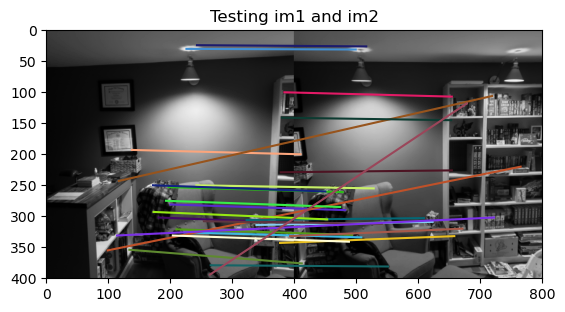

In [46]:
# Match im1 and im2
key12, key21, matches_12 = applySIFT(im1, im2, every_n_element=10, plot=True, title='Testing im1 and im2')

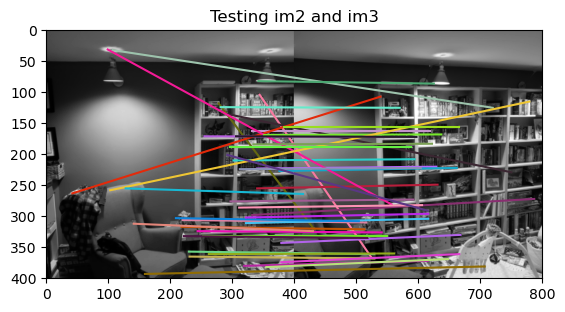

In [47]:
# Match im2 and im3
key23, key32, matches_23 = applySIFT(im2, im3, every_n_element=10, plot=True, title='Testing im2 and im3')

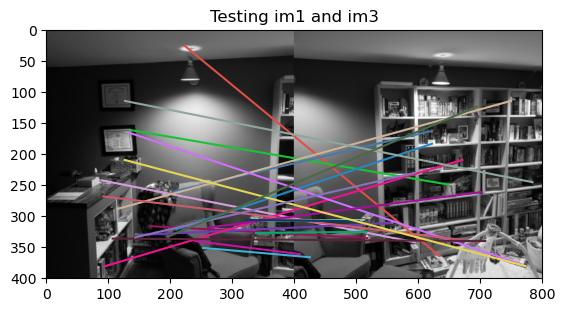

In [48]:
# Match im1 and im3 # Don't actually need this at all since I'll be mapping 1-2 and 2-3.
key13, key31, matches_13 = applySIFT(im1, im3, every_n_element=10, plot=True, title='Testing im1 and im3')

RANSAC and Trasnforms For image 1-2

In [113]:
# The source image coordinates for matched features (image 1)
src_12 = key12[matches_12[:,0]][:,::-1] # reverse the list
# The destination image coordinates for matched features (image 2)
dst_12 = key21[matches_12[:,1]][:,::-1] # reverse the list

# The model here is from the ProjectiveTransform model with the largest consensus set
# The model is of the ProjectiveTransform class which has params of a homogeneous transformation matrix
# The good_data_## are the inliers classified as True
model_ransac_12, inliers_12 = ski.measure.ransac((src_12, dst_12), ski.transform.ProjectiveTransform, min_samples=3,
                                             residual_threshold=2, max_trials=1000)

outliers_12 = (inliers_12 == False)

In [114]:
# The good RANSAC projective transformation matrix
model_ransac_12

<ProjectiveTransform(matrix=
    [[ 1.42151605e+00, -1.08905436e-02, -1.84438098e+02],
     [ 1.80063638e-01,  1.20144856e+00, -3.13424707e+01],
     [ 1.01185860e-03, -7.92014193e-05,  1.00000000e+00]]) at 0x285a8c73f50>

In [115]:
# This is the 'bad' non-RANSAC matrix I'll be using in comparision at the end
bad_model_12 = ski.transform.ProjectiveTransform()
bad_model_12.estimate(src_12,dst_12)
bad_model_12

<ProjectiveTransform(matrix=
    [[-3.06774503e+01,  3.42487716e+00,  3.71774108e+03],
     [-2.60979229e+01, -1.26266341e+01,  6.44938629e+03],
     [-9.74781374e-02,  3.33083565e-02,  1.00000000e+00]]) at 0x285a7f79ca0>

For image 2-3

In [116]:
# The source image coordinates for matched features (image 3)
src_23 = key32[matches_23[:,1]][:,::-1] # reverse list
# The destination image coordinates for matched features (image 2)
dst_23 = key23[matches_23[:,0]][:,::-1] # reverse list

# The model here is from the ProjectiveTransform model with the largest consensus set
# The model is of the ProjectiveTransform class which has params of a homogeneous transformation matrix
# The good_data_## are the inliers classified as True
model_ransac_23, inliers_23 = ski.measure.ransac((src_23,dst_23), ski.transform.ProjectiveTransform, min_samples=3,
                                             residual_threshold=2, max_trials=1000)

outliers_23 = (inliers_23 == False)

In [117]:
# The good RANSAC projective transformation matrix
model_ransac_23

<ProjectiveTransform(matrix=
    [[ 7.75760544e-01, -2.28260038e-02,  1.24930933e+02],
     [-8.36771361e-02,  9.31650372e-01,  1.00884810e+01],
     [-5.75156026e-04,  3.70519696e-05,  1.00000000e+00]]) at 0x285a86b4260>

In [118]:
# This is the 'bad' non-RANSAC matrix I'll be using in comparision at the end
bad_model_23 = ski.transform.ProjectiveTransform()
bad_model_23.estimate(src_23,dst_23)
bad_model_23

<ProjectiveTransform(matrix=
    [[-3.53762805e-01, -1.09766276e-01,  1.89478162e+02],
     [-6.65165128e-01,  3.39352243e-01,  1.37551660e+02],
     [-2.78678257e-03, -3.53173378e-04,  1.00000000e+00]]) at 0x285a8eda7b0>

See if the RANSAC made things better

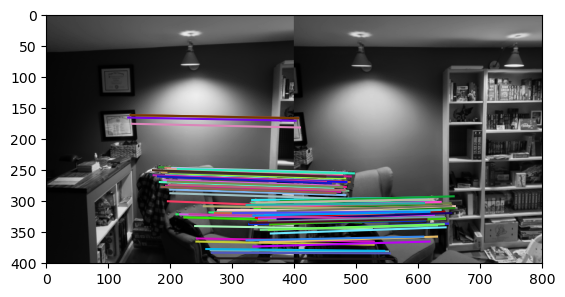

In [119]:
fig, ax = plt.subplots(1, 1)

ski.feature.plot_matches(ax, im1, im2, key12, key21, matches_12[inliers_12], only_matches=True)

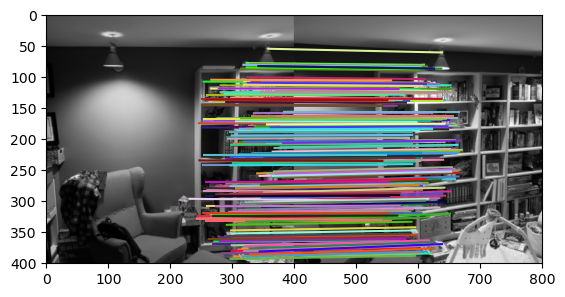

In [120]:
fig, ax = plt.subplots(1, 1)

ski.feature.plot_matches(ax, im2, im3, key23, key32, matches_23[inliers_23], only_matches=True)

A much better listing of matches.  Note how there are no blatant lines crossing.  Lines being parallel is (or nearly given the projective transform that is needed) is what I'm looking for.

## A lack of Matlab Functions

From here on, the quick code to perform AlphaBlending in Matlab does not exist.  Here, I make the 'empty' panorama, which I call the canvas and apply transforms to the images to align them upon the canvas.

# Stitching the images

I'll have to do this with a similarity transform (https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.SimilarityTransform).  This is an extention of the Euclidean Transform which applies a scaling factor in addition to translation and rotation.

In [121]:
# Impor the Similarity Transform (it took me a long time to find this Class)
from skimage.transform import SimilarityTransform

The goal here is to take the middle image (im2) and transform the images around it (im1 and im3) to match.  Given the way a panorama is typically taken, the photographer pivoting their camera from a stationary location, this will allow the projection transform used in the RANSAC to be applied.  Before applying this, we must move the images to proper locations so they images align in space.

In [122]:
row, col = im2.shape

In [123]:
# Set the corners of image 2

    # In what can only be described as annoying, the transformations use x,y rather than row,col.
    # Convert row, col to x,y

im2_corners = np.array([[0,0], [0,row], [col,0],[row,col]])

In [124]:
# Let us see what the model_ransac_12 gives us again
model_ransac_12

<ProjectiveTransform(matrix=
    [[ 1.42151605e+00, -1.08905436e-02, -1.84438098e+02],
     [ 1.80063638e-01,  1.20144856e+00, -3.13424707e+01],
     [ 1.01185860e-03, -7.92014193e-05,  1.00000000e+00]]) at 0x285a8c73f50>

The model_ransac gives us a Projective Transform which we can pass position values to to project them by the transformation matrix.

In [125]:
# I need to translate the corners of im1 and im3 to their locations while applying the projection
# I can do this by taking the ProjectiveTransform matrix contained in the RANSAC model and
#  apply it by the corner position for im2 (im2_corners).  This helps set where im1 and im3 will be.
translate_corners12 = model_ransac_12(im2_corners)
translate_corners23 = model_ransac_23(im2_corners)

# This is being done for the non-RANSAC data as well for comparision
bad_translate_corners12 = bad_model_12(im2_corners)
bad_translate_corners23 = bad_model_23(im2_corners)

Let's look at the corner positions we have now.

In [126]:
# Image 1
translate_corners12

array([[-184.43809763,  -31.34247068],
       [-194.97111052,  463.93466581],
       [ 273.4793497 ,   28.96114917],
       [ 276.61668864,  379.63476934]])

In [127]:
# Image 2 (These are just the im2.shape given we don't want to move this... yet)
im2_corners

array([[  0,   0],
       [  0, 400],
       [400,   0],
       [400, 400]])

In [128]:
# Image 3
translate_corners23

array([[124.93093318,  10.088481  ],
       [114.10934134, 377.15883871],
       [565.2862735 , -30.36918023],
       [542.97572552, 445.07683577]])

With these three corner sets, I'll be able to determine how large of an image canvas to build for the panorama stitching.

In [129]:
# Stack the matricies so I can look at them via numpy
corner_set = np.vstack((translate_corners12, im2_corners, translate_corners23))

# For the bad match
bad_corner_set = np.vstack((bad_translate_corners12, im2_corners, bad_translate_corners23))

In [130]:
# Find the minimum and maximum corner positions as well as the general shape
corner_min = np.min(corner_set, axis=0)
corner_max= np.max(corner_set, axis=0)

canvas_shape = (corner_max - corner_min)
corner_min, corner_max, canvas_shape


# For the bad data
bad_corner_min = np.min(bad_corner_set, axis=0)
bad_corner_max= np.max(bad_corner_set, axis=0)

bad_canvas_shape = (bad_corner_max - bad_corner_min)

In [132]:
# In a more classic annoyance, I know that my image should be wider than tall.
# I need to swap the canvas_shape array items.  I should also make them ints.

canvas_shape = np.ceil(canvas_shape[::-1]).astype(int)
canvas_shape


# Doing this for the bad data
bad_canvas_shape = np.ceil(bad_canvas_shape[::-1]).astype(int)

Now we have our Canvas for placing our images which was given by the image corners obtained via the RANSAC's Projective Transform.

# Apply Various Affine Transforms

In [133]:
# I need to move the center image due to the corner_min existing at some projected point.
# This will shift the middle image to the right and up (- of the negative corner_min values)
# We have to do this because the projection of the other images may lift them above or below
# the postion of im2.

# Create the shift
shift = ski.transform.SimilarityTransform(translation= -corner_min)

# Use the Warp class to apply the transform.
# NOTE: The warp uses the INVERSE_MAP on the image.  Thus, I'll take the inverse of the shift_im2 transform matrix
# order=3 corresponds to a bi-cubic interpolation
# cval= -1 corresponds to values outside the image bounds (we'll use this for masking)
im2_warp = ski.transform.warp(im2, shift.inverse, order=3, output_shape=canvas_shape, cval=-1)

# It will also be useful to understand where the image is in terms of masking it for later.
# The -1 value was set by cval above.
im2_mask = (im2_warp != -1)
# Set the background from the mask to zero
im2_warp[~im2_mask] = 0



# Do all of the above but with the bad data
# Create the shift
bad_shift = ski.transform.SimilarityTransform(translation= -bad_corner_min)

# Use the Warp class to apply the transform.
# NOTE: The warp uses the INVERSE_MAP on the image.  Thus, I'll take the inverse of the shift_im2 transform matrix
# order=3 corresponds to a bi-cubic interpolation
# cval= -1 corresponds to values outside the image bounds (we'll use this for masking)
bad_im2_warp = ski.transform.warp(im2, bad_shift.inverse, order=3, output_shape=bad_canvas_shape, cval=-1)

# It will also be useful to understand where the image is in terms of masking it for later.
# The -1 value was set by cval above.
bad_im2_mask = (bad_im2_warp != -1)
# Set the background from the mask to zero
bad_im2_warp[~bad_im2_mask] = 0

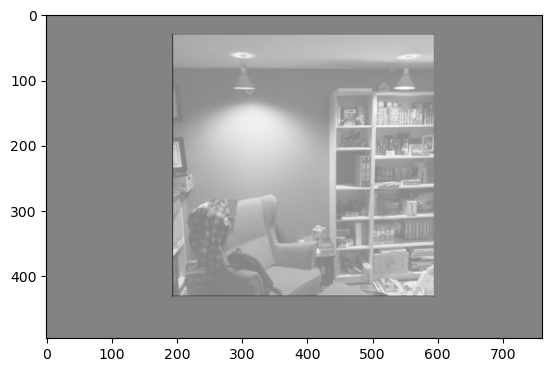

In [134]:
# We see here now where im2 exists when warped to position on the canvas
plt.imshow(im2_warp, cmap='gray');

Let us now move image 1 (left) and image 3 (right) into place.

In [135]:
# For image 1 (left)

# We need to shift im1 as well as apply model_ransac_12 to it.
# I can add the transformation matricies together to do this.
multi_transform_im1 = (model_ransac_12 + shift)

# Apply the warp
im1_warp = ski.transform.warp(im1, multi_transform_im1.inverse, order=3, output_shape=canvas_shape, cval=-1)

# Get the mask for im1 (left)
im1_mask = (im1_warp != -1)
im1_warp[~im1_mask] = 0

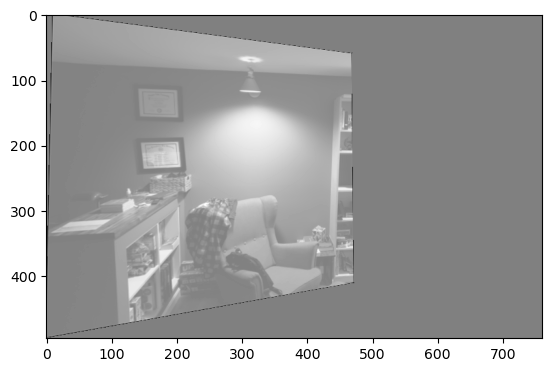

In [136]:
plt.imshow(im1_warp);

In [137]:
# For the bad data and im1
bad_multi_transform_im1 = (bad_model_12 + bad_shift)

# Apply the warp
bad_im1_warp = ski.transform.warp(im1, bad_multi_transform_im1.inverse, order=3, output_shape=bad_canvas_shape, cval=-1)

# Get the mask for im1 (left)
bad_im1_mask = (bad_im1_warp != -1)
bad_im1_warp[~bad_im1_mask] = 0

In [138]:
# For image 3 (right)

# We need to shift im3 as well as apply model_ransac_23 to it.
# I can add the transformation matricies together to do this.
multi_transform_im3 = (model_ransac_23 + shift)

# Apply the warp
im3_warp = ski.transform.warp(im3, multi_transform_im3.inverse, order=3, output_shape=canvas_shape, cval=-1)

# Get the mask for im1 (left)
im3_mask = (im3_warp != -1)
im3_warp[~im3_mask] = 0

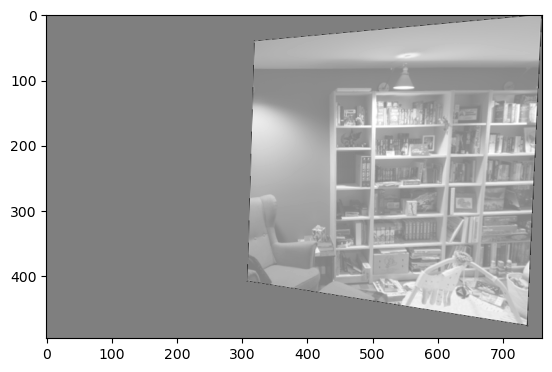

In [139]:
plt.imshow(im3_warp);

In [140]:
# For the bad data and im3
bad_multi_transform_im3 = (bad_model_23 + bad_shift)

# Apply the warp
bad_im3_warp = ski.transform.warp(im3, bad_multi_transform_im3.inverse, order=3, output_shape=bad_canvas_shape, cval=-1)

# Get the mask for im1 (left)
bad_im3_mask = (bad_im3_warp != -1)
bad_im3_warp[~bad_im3_mask] = 0

What should this look like side by side?

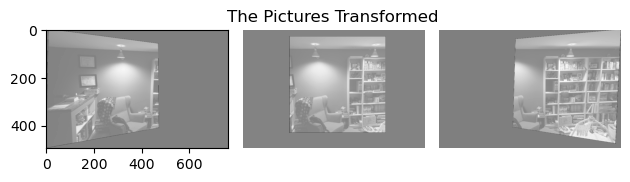

In [141]:
# Showing the resized pictures to be stitched
fig, axs = plt.subplots(1,3)

axs[0].imshow(im1_warp, cmap='gray')
# axs[0].axis('off')
axs[1].imshow(im2_warp, cmap='gray')
axs[1].axis('off')
axs[2].imshow(im3_warp, cmap='gray')
axs[2].axis('off')

axs[1].set_title('The Pictures Transformed')

plt.tight_layout()

We can begin to see now how the panorama is being constructed.  Furthermore, we understand why we had to shift im2 by the negative of corner_min so that it sat down lower allow for the left and right images to properly align due to the projection transformation.

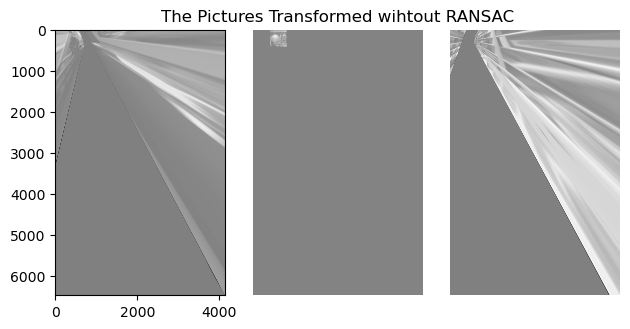

In [142]:
# For the bad data
fig, axs = plt.subplots(1,3)

axs[0].imshow(bad_im1_warp, cmap='gray')
# axs[0].axis('off')
axs[1].imshow(bad_im2_warp, cmap='gray')
axs[1].axis('off')
axs[2].imshow(bad_im3_warp, cmap='gray')
axs[2].axis('off')

axs[1].set_title('The Pictures Transformed wihtout RANSAC')

plt.tight_layout()

As for the bad, non-RANSAC image, this is a mess.

# Blending Images

At this point, we have the images how we want them, we need to stitch them together though.

The simpliest way to do this is to just add the images together (total_image).  As we will see, this will leave a number of artifacts and will change intensity of objects based on how many overlaps exist within the images.

An intermediate way would be to use the masks (one for each image) we found above.  We can then use total_image and normalize it by the maximum values within the total mask area.  This is better, but there are still some artifacts which remain where the image borders exist.

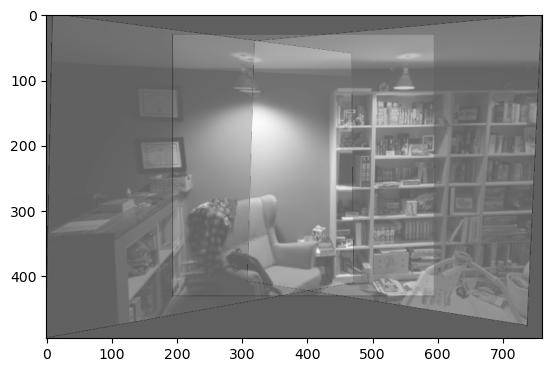

In [143]:
# Simple method, just add the images together
total_image = im1_warp + im2_warp + im3_warp
plt.imshow(total_image);


As stated before, the artifacts are clearly seen.  The chair also changes intensity from multiply overlaps of images.  To get rid of intensity shifts, we should create a total mask by summing the individuals masks and then use that to mask normalize the image.

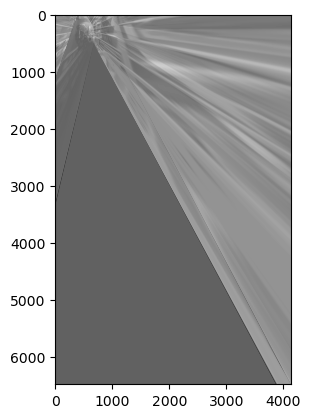

In [144]:
# The bad data
bad_total_image = bad_im1_warp + bad_im2_warp + bad_im3_warp
plt.imshow(bad_total_image);

Given that you can't even really tell what is going on in the bad image, I won't go through the trouble or normalizing it.

Going back to normalizing the properly RANSAC'd data...

In [145]:
# Use the total_mask and normalize the image over the total_mask region.

# Compute the total mask
# Each im#_mask is a bool, convert each to a float and then add
# You need to get the overlapping region to have higher mask values for
#  the division during the normalization
total_mask = (im1_mask*1.0) + (im2_mask*1.0) + (im3_mask*1.0)
# Convert the bool to a float
total_mask = total_mask* 1.0
total_mask

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [146]:
# Check to see if you have a max of 3 (the center of the image has all 3 overlapped on it)
np.max(total_mask)

3.0

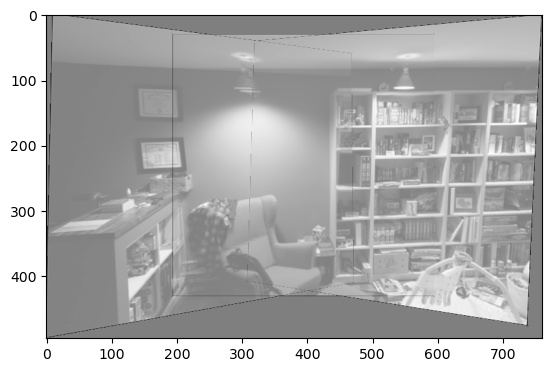

In [147]:
# Normalize the image over the total_mask region
norm_total_im = total_image / np.maximum(total_mask,1)

plt.imshow(norm_total_im, cmap='gray')

Notice now that we have a more uniformly blended image.  We still suffer from the vertical line artifacts that were introduced with the `warp` method by using bi-cubic interpolation.  If the nearest neighbor approch is used instead, the vertical lines are removed, but we have a image that suffers in other ways due to poor interpolation.

# An alternative to Blending - The Jigsaw

During my research, I found another way to bring multiple images together to create a panorama though it is much, much more complicated.

In short, the process involves using a Minimum-Cost Path (MCP) using `skimage.graph`.  This allows for a mask to be created for each image along the MCP found.  From here, each image can then be placed adjacent to the next in a jigsaw type manner.  Because of this, we are not blending intensity values and then renormalizing, we would simply be setting relevant pieces of the images next to one another to construct the panorama.

Interested individuals can find more information in the paper by Sruthi P & Sruthi Dinesh (2017): https://www.iosrjournals.org/iosr-jece/papers/Conf.17013-2017/Volume-1/4.%2012-24.pdf